<a href="https://colab.research.google.com/github/Praneethreddy914/garbage-classification-/blob/main/garbage_classification(week_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praneethreddy799","key":"0f40de0c9869d2e112ef67fa3614a4b9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset


Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
  0% 0.00/40.9M [00:00<?, ?B/s]
100% 40.9M/40.9M [00:00<00:00, 706MB/s]


In [ ]:
!unzip trash-type-image-dataset.zip -d trash_dataset


Archive:  trash-type-image-dataset.zip
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_001.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_002.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_003.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_004.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_005.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_006.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_007.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_008.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_009.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_010.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard_011.jpg  
  inflating: trash_dataset/TrashType_Image_Dataset/cardboard/cardboard

In [ ]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    "trash_dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "trash_dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:

print(train_ds.class_names)
print(val_ds.class_names)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


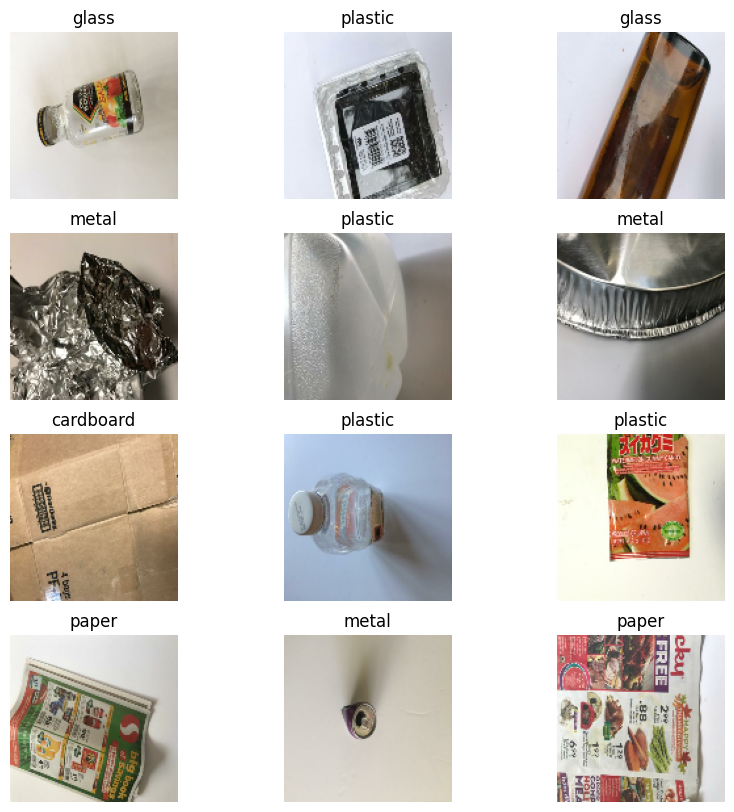

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

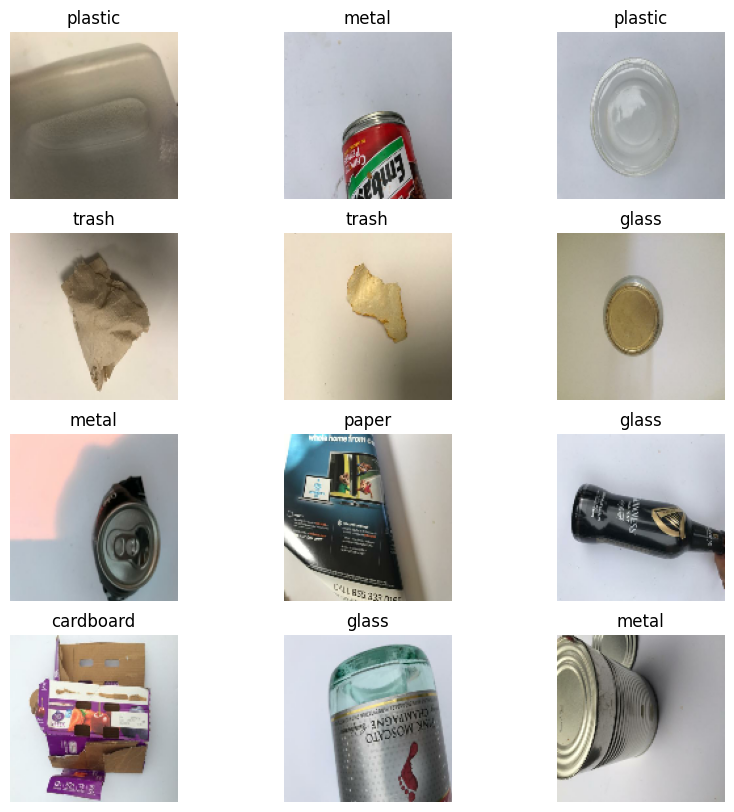

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [ ]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [ ]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


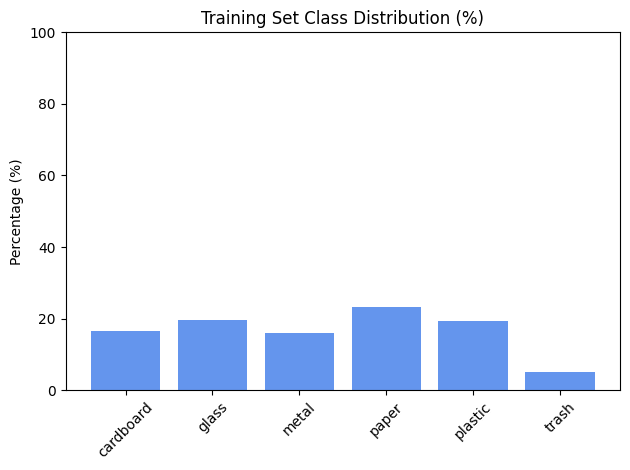

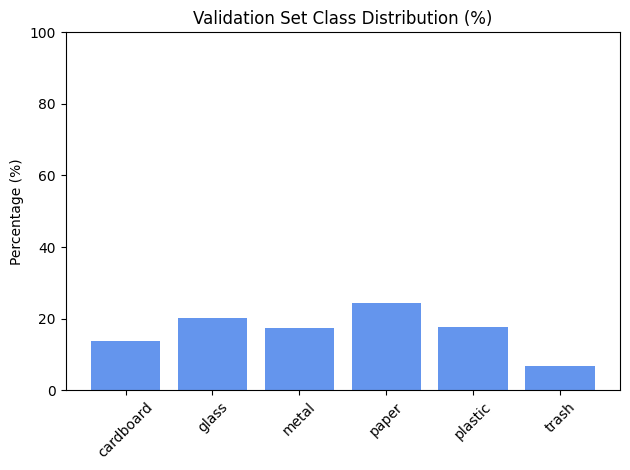

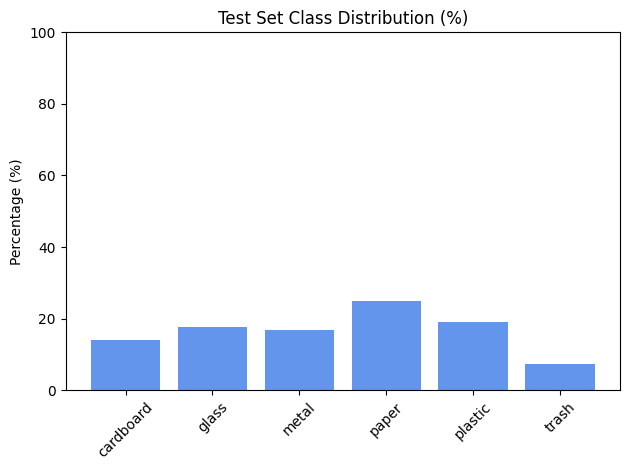

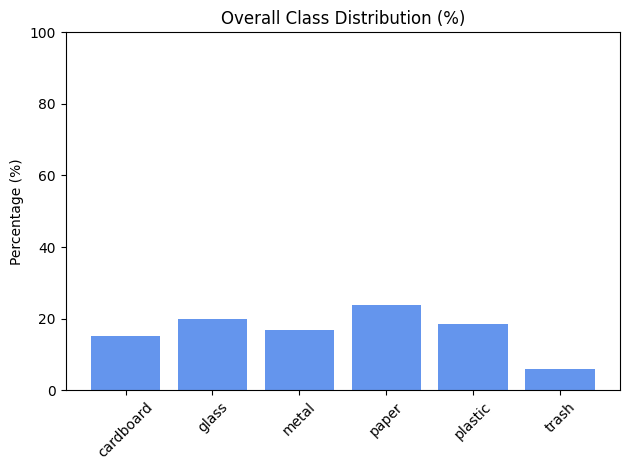

In [ ]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [ ]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [ ]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
# Data Augmentation for training data
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.0),
    layers.RandomContrast(0.1),
])
# Apply augmentation and EfficientNet preprocessing
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
# Prefetch for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import EfficientNetV2B2

# Load pre-trained EfficientNetV2B2 base
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base model

# Build model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # output logits (no softmax)
])

# Compile
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.6285 - loss: 1.0171 - val_accuracy: 0.8574 - val_loss: 0.3938
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8837 - loss: 0.3391 - val_accuracy: 0.8812 - val_loss: 0.3416
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.9150 - loss: 0.2570 - val_accuracy: 0.8950 - val_loss: 0.3132
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.9382 - loss: 0.2074 - val_accuracy: 0.8950 - val_loss: 0.2913
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9358 - loss: 0.2018 - val_accuracy: 0.9069 - val_loss: 0.2768
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.9490 - loss: 0.1612 - val_accuracy: 0.9129 - val_loss: 0.2703
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.9457 - loss: 0.1508 - val_accuracy: 0.9069 - val_loss: 0.2624
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9500 - loss: 0.1509 - val_accuracy: 0.9149 - v

In [ ]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,312,754 (35.53 MB)

 Trainable params: 181,126 (707.52 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

 Optimizer params: 362,254 (1.38 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          0 │ rescaling_3[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

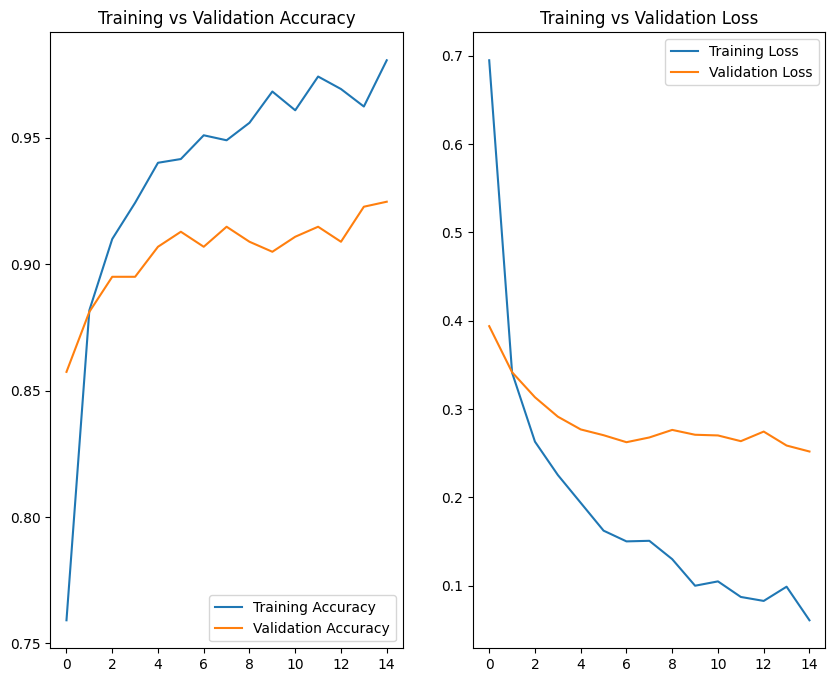

In [ ]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [ ]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 816ms/step - accuracy: 0.9470 - loss: 0.1495
Test accuracy is0.9375, Test loss is 0.1644


In [ ]:
test_ds_eval = tf.keras.utils.image_dataset_from_directory(
    "trash_dataset/TrashType_Image_Dataset",            # ✅ actual test folder path
    image_size=(224, 224),
    batch_size=32,
    shuffle=False,
    label_mode='int'
)

test_ds_eval = test_ds_eval.map(lambda x, y: (preprocess_input(x), y))


Found 2527 files belonging to 6 classes.


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert batched test labels into a flat numpy array
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)

# 2. Get predicted probabilities from the model
y_pred_probs = model.predict(test_ds_eval)

# 3. Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# 4. Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# 5. Print detailed classification metrics
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


79/79 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step
Confusion Matrix:
 [[400   0   0   3   0   0]
 [  0 494   4   1   2   0]
 [  0   3 403   1   1   2]
 [  2   0   0 587   2   3]
 [  0   6   0   2 473   1]
 [  1   0   3   3   1 129]]

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99       403
       glass       0.98      0.99      0.98       501
       metal       0.98      0.98      0.98       410
       paper       0.98      0.99      0.99       594
     plastic       0.99      0.98      0.98       482
       trash       0.96      0.94      0.95       137

    accuracy                           0.98      2527
   macro avg       0.98      0.98      0.98      2527
weighted avg       0.98      0.98      0.98      2527



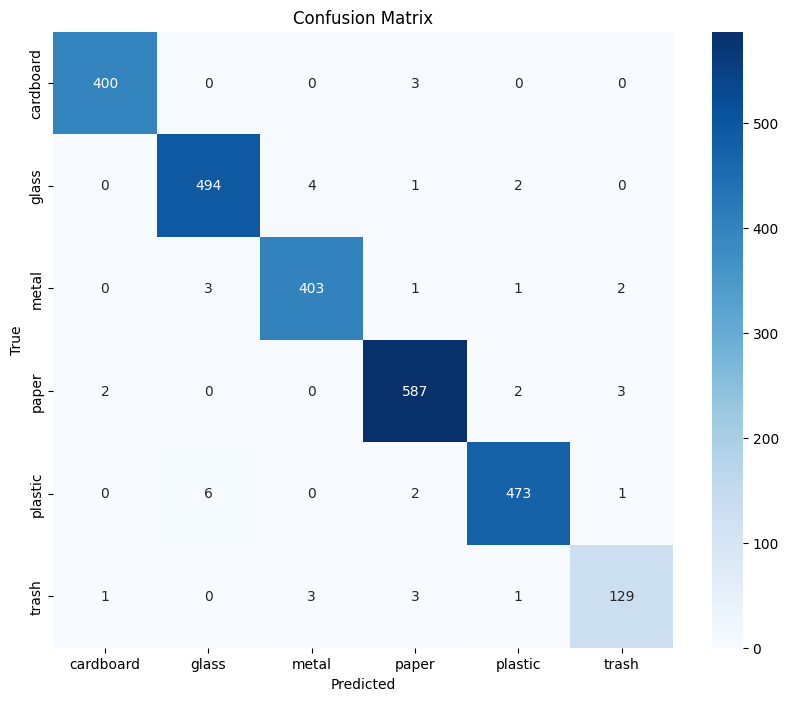

In [ ]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

In [ ]:
# Load dataset (from directory)
train_ds_raw = tf.keras.utils.image_dataset_from_directory("trash_dataset/TrashType_Image_Dataset")

# Extract class names BEFORE applying prefetch
class_names = train_ds_raw.class_names

# Now apply prefetch to optimize performance
train_ds = train_ds_raw.prefetch(buffer_size=tf.data.AUTOTUNE)

# Use class_names safely now
print(class_names)


Found 2527 files belonging to 6 classes.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Found 2527 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


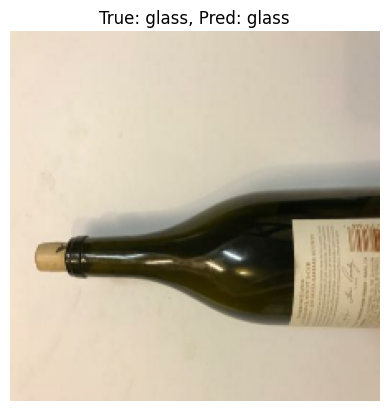

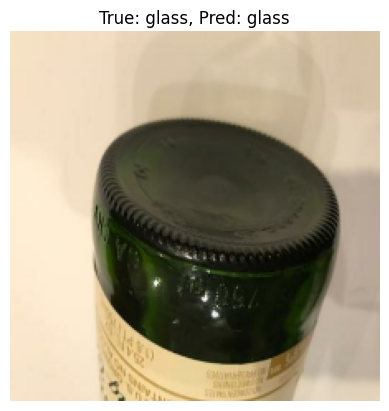

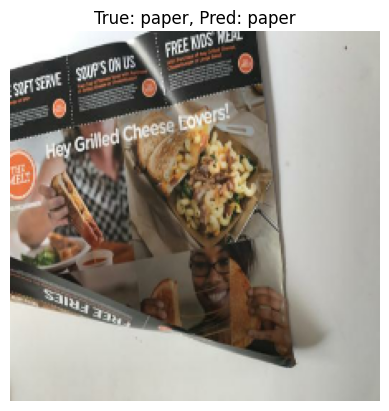

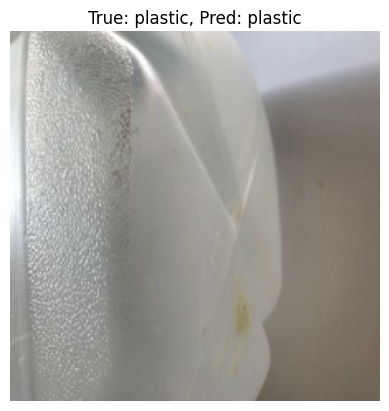

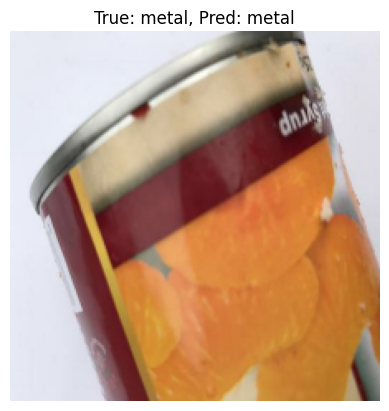

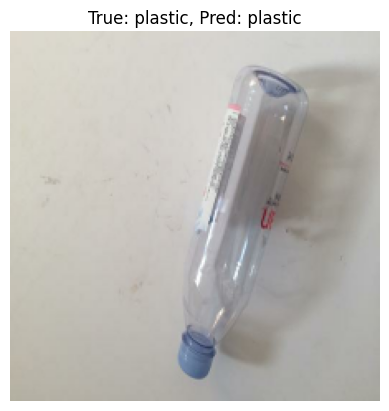

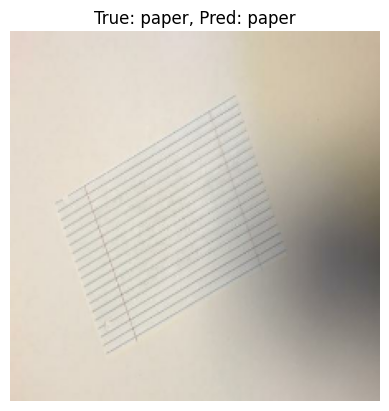

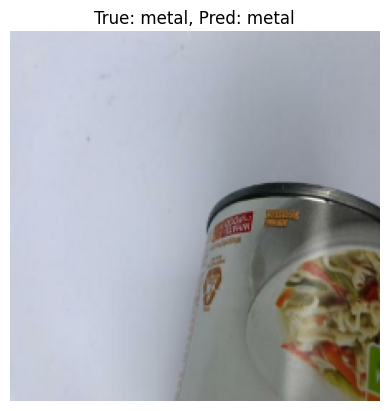

In [ ]:
# Load training dataset and extract class names before prefetching
train_ds_raw = tf.keras.utils.image_dataset_from_directory("trash_dataset/TrashType_Image_Dataset")
class_names = train_ds_raw.class_names
train_ds = train_ds_raw.prefetch(buffer_size=tf.data.AUTOTUNE)

# Take one batch from the test dataset
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')